<a href="https://colab.research.google.com/github/anshudaur/TensorFlowProjects/blob/master/keras_01_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Parameters

In [1]:
BATCH_SIZE = 128
EPOCHS = 10

training_images_file   = 'gs://mnist-public/train-images-idx3-ubyte'
training_labels_file   = 'gs://mnist-public/train-labels-idx1-ubyte'
validation_images_file = 'gs://mnist-public/t10k-images-idx3-ubyte'
validation_labels_file = 'gs://mnist-public/t10k-labels-idx1-ubyte'

### Imports

In [2]:
import os, re, math, json, shutil, pprint
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import IPython.display as display
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.3.0


### tf.data.Dataset: parse files and prepare training and validation datasets

In [4]:
AUTO = tf.data.experimental.AUTOTUNE

def read_label(tf_bytestring):
    label = tf.io.decode_raw(tf_bytestring, tf.uint8)
    label = tf.reshape(label, [])
    label = tf.one_hot(label, 10)
    return label
  
def read_image(tf_bytestring):
    image = tf.io.decode_raw(tf_bytestring, tf.uint8)
    image = tf.cast(image, tf.float32)/256.0
    image = tf.reshape(image, [28*28])
    return image
  
def load_dataset(image_file, label_file):
    imagedataset = tf.data.FixedLengthRecordDataset(image_file, 28*28, header_bytes=16)
    imagedataset = imagedataset.map(read_image, num_parallel_calls=16)
    labelsdataset = tf.data.FixedLengthRecordDataset(label_file, 1, header_bytes=8)
    labelsdataset = labelsdataset.map(read_label, num_parallel_calls=16)
    dataset = tf.data.Dataset.zip((imagedataset, labelsdataset))
    return dataset 
  
def get_training_dataset(image_file, label_file, batch_size):
    dataset = load_dataset(image_file, label_file)
    dataset = dataset.cache()  # this small dataset can be entirely cached in RAM, for TPU this is important to get good performance from such a small dataset
    dataset = dataset.shuffle(5000, reshuffle_each_iteration=True)
    dataset = dataset.repeat() # Mandatory for Keras for now
    dataset = dataset.batch(batch_size, drop_remainder=True) # drop_remainder is important on TPU, batch size must be fixed
    dataset = dataset.prefetch(AUTO)  # fetch next batches while training on the current one (-1: autotune prefetch buffer size)
    return dataset
  
def get_validation_dataset(image_file, label_file):
    dataset = load_dataset(image_file, label_file)
    dataset = dataset.cache() # this small dataset can be entirely cached in RAM, for TPU this is important to get good performance from such a small dataset
    dataset = dataset.batch(10000, drop_remainder=True) # 10000 items in eval dataset, all in one batch
    dataset = dataset.repeat() # Mandatory for Keras for now
    return dataset

# instantiate the datasets
training_dataset = get_training_dataset(training_images_file, training_labels_file, BATCH_SIZE)
validation_dataset = get_validation_dataset(validation_images_file, validation_labels_file)

# For TPU, we will need a function that returns the dataset
training_input_fn = lambda: get_training_dataset(training_images_file, training_labels_file, BATCH_SIZE)
validation_input_fn = lambda: get_validation_dataset(validation_images_file, validation_labels_file)

### Let's have a look at the data

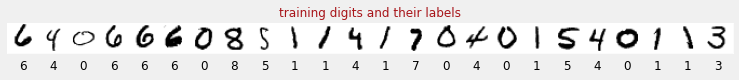

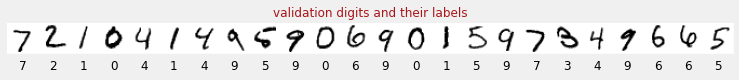

In [5]:
N = 24
(training_digits, training_labels,
 validation_digits, validation_labels) = dataset_to_numpy_util(training_dataset, validation_dataset, N)
display_digits(training_digits, training_labels, training_labels, "training digits and their labels", N)
display_digits(validation_digits[:N], validation_labels[:N], validation_labels[:N], "validation digits and their labels", N)
font_digits, font_labels = create_digits_from_local_fonts(N)

In [6]:
model = tf.keras.Sequential(
  [
      tf.keras.layers.Input(shape=(28*28,)),
      tf.keras.layers.Dense(10, activation='softmax')
  ])

model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# print model layers
model.summary()

# utility callback that displays training curves
plot_training = PlotTraining(sample_rate=10, zoom=1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


### Train and validate the model

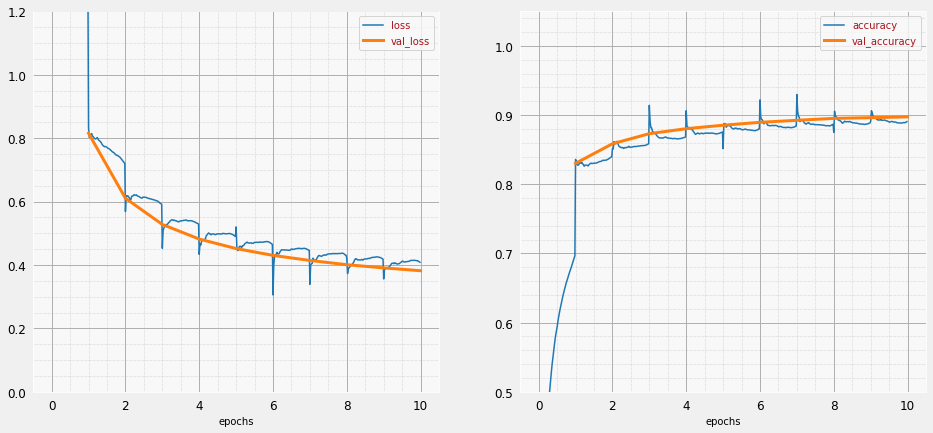

468/468 [==============================] - 3s 6ms/step - loss: 0.4073 - accuracy: 0.8909 - val_loss: 0.3818 - val_accuracy: 0.8974


In [7]:
steps_per_epoch = 60000//BATCH_SIZE  # 60,000 items in this dataset
print("Steps per epoch: ", steps_per_epoch)

history = model.fit(training_dataset, steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                    validation_data=validation_dataset, validation_steps=1, callbacks=[plot_training])

### Visualize predictions

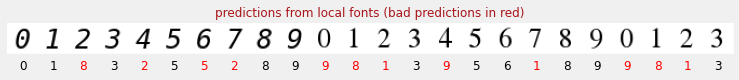

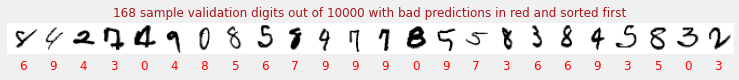

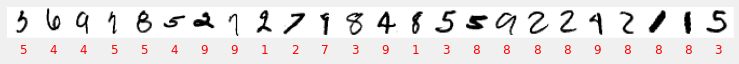

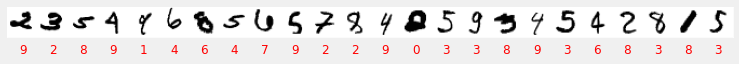

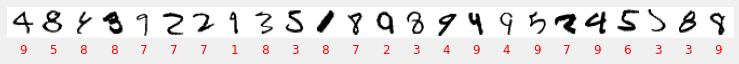

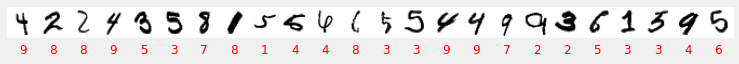

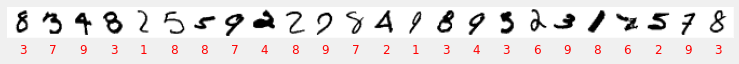

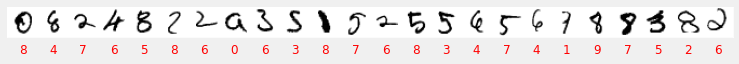

In [8]:
# recognize digits from local fonts
probabilities = model.predict(font_digits, steps=1)
predicted_labels = np.argmax(probabilities, axis=1)
display_digits(font_digits, predicted_labels, font_labels, "predictions from local fonts (bad predictions in red)", N)

# recognize validation digits
probabilities = model.predict(validation_digits, steps=1)
predicted_labels = np.argmax(probabilities, axis=1)
display_top_unrecognized(validation_digits, predicted_labels, validation_labels, N, 7)